In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import torch
plt.rcParams['figure.figsize'] = [18, 12]

In [2]:
result = np.loadtxt('output.txt')

In [3]:
result.shape

(705600,)

In [4]:
result = result.reshape(84, 8400)

In [5]:
result.shape

(84, 8400)

In [6]:
result = result.transpose()

In [7]:
result.shape

(8400, 84)

In [8]:
rows=result.shape[0]

In [9]:
rows

8400

In [10]:
boxes = []
scores = []
class_ids = []

# Iterate through output to collect bounding boxes, confidence scores, and class IDs
for i in range(rows):
    classes_scores = result[i][4:]
    (minScore, maxScore, minClassLoc, (x, maxClassIndex)) = cv2.minMaxLoc(classes_scores)
    if maxScore >= 0.25:
        box = [
            result[i][0] - (0.5 * result[i][2]),
            result[i][1] - (0.5 * result[i][3]),
            result[i][2],
            result[i][3],
        ]
        boxes.append(box)
        scores.append(maxScore)
        class_ids.append(maxClassIndex)

In [11]:
result_boxes = cv2.dnn.NMSBoxes(boxes, scores, 0.25, 0.45, 0.5)

In [12]:
result_boxes

array([10, 14,  4,  0], dtype=int32)

In [13]:
from ultralytics.utils import ASSETS, yaml_load
from ultralytics.utils.checks import check_yaml
CLASSES = yaml_load(check_yaml("coco.yaml"))["names"]
colors = np.random.uniform(0, 255, size=(len(CLASSES), 3))

In [14]:
def draw_bounding_box(image, class_id, confidence, x, y, x_plus_w, y_plus_h):
    """
    Draws bounding boxes on the input image based on the provided arguments.

    Args:
        img (numpy.ndarray): The input image to draw the bounding box on.
        class_id (int): Class ID of the detected object.
        confidence (float): Confidence score of the detected object.
        x (int): X-coordinate of the top-left corner of the bounding box.
        y (int): Y-coordinate of the top-left corner of the bounding box.
        x_plus_w (int): X-coordinate of the bottom-right corner of the bounding box.
        y_plus_h (int): Y-coordinate of the bottom-right corner of the bounding box.
    """
    label = f"{CLASSES[class_id]} ({confidence:.2f})"
    color = colors[class_id]
    cv2.rectangle(image, (x, y), (x_plus_w, y_plus_h), color, 2)
    cv2.putText(image, label, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

In [15]:
scale_ratio = 1
dw = 0
dh = 107

In [16]:
detections = []

# Iterate through NMS results to draw bounding boxes and labels
for i in range(len(result_boxes)):
    index = result_boxes[i]
    box = boxes[index]
    detection = {
        "class_id": class_ids[index],
        "class_name": CLASSES[class_ids[index]],
        "confidence": scores[index],
        "box": box,
        "scale": scale_ratio,
    }
    detections.append(detection)

In [17]:
detections

[{'class_id': 3,
  'class_name': 'motorcycle',
  'confidence': 0.78125,
  'box': [27.25, 202.0625, 151.0, 211.375],
  'scale': 1},
 {'class_id': 3,
  'class_name': 'motorcycle',
  'confidence': 0.75,
  'box': [409.53125, 182.5, 207.875, 248.5],
  'scale': 1},
 {'class_id': 3,
  'class_name': 'motorcycle',
  'confidence': 0.375,
  'box': [332.40625, 321.3125, 68.1875, 67.5],
  'scale': 1},
 {'class_id': 0,
  'class_name': 'person',
  'confidence': 0.28125,
  'box': [473.25, 181.203125, 30.625, 31.21875],
  'scale': 1}]

In [18]:
# img = np.loadtxt('d_1_3_640_640.tensor')
# img = img.reshape(3, 640, 640)
# img = img * 255
# img = img.transpose(1, 2, 0)
# img = img.astype(np.uint8)
# img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

In [19]:
img = cv2.imread('000000566261.jpg')
if img is None:
    raise FileNotFoundError(f"Image Not Found {img_path}")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [20]:
for detection in detections:
    box = detection['box']
    scale = detection['scale']
    draw_bounding_box(
        img,
        detection['class_id'],
        detection['confidence'],
        round((box[0] - (dw)) / scale),
        round((box[1] - (dh)) / scale),
        round((box[0] + box[2] - (dw)) / scale),
        round((box[1] + box[3] - (dh)) / scale),
    )

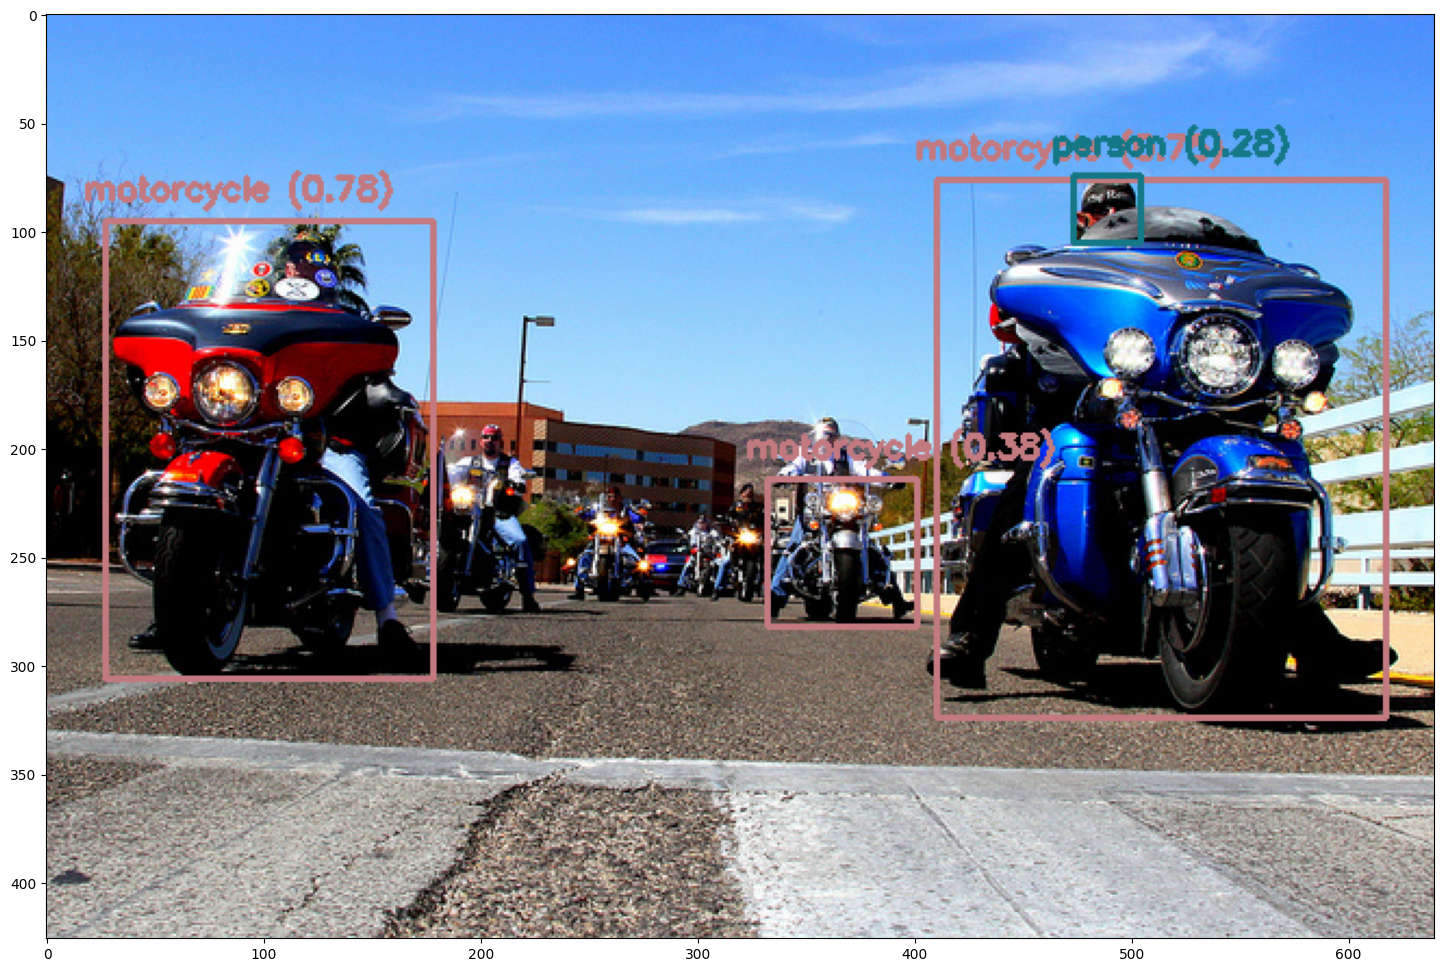

In [21]:
plt.imshow(img)
plt.show()